# Data preprocessing

Our dataset parsed from readme files is not very suitable as is for machine learning techniques since features have different measure units and there are some features that are related to others so the dimensionality is unnecessarily high. Hence some feature scaling is being done in this notebook.

## Manual scaling and dimensionality reduction

In the beginning, we do some manual scaling. It includes merge of related features into one in (hopefully) appropriate way and normalizing each feature to be in range [0, 1]. Some features are just copied (and then normalized) because they are not related to another at all.

The result of scaling is saved to `manually-scaled.csv` file and then basic statistics are shown.

In [6]:
# manual features scaling and dimensionality reduction (merge of related features)

import pandas as pd
import numpy as np
import math

data = pd.read_csv('../data/raw.csv', usecols=list(range(1, 26)))

# make logarithm function "working" with zero values
def logz(x):
    if x != 0:
        return math.log(x)
    else:
        return 0
    
def scale_cbs(count, length):
    if count != 0:
        return float(length) / count
    else:
        return 0

def scale_usage(text_len, code_len, code_count, link):
    code_ratio = 0
    if code_count != 0:
        code_ratio = float(code_len) / code_count
    
    # compute average of text length and code ratio,
    # we assume that more code == better usage section (hence bigger weigth)
    # but it can be wrong interference
    text_code_ratio = np.average([text_len, code_ratio], weights=[0.25, 0.75])
    
    # we want to make better score when there is a link
    # but non-zero score when there is no link
    link_coeff = math.exp(link)
    
    # strenghen score by link presence coefficient
    score = text_code_ratio * link_coeff
    
    # we want to distinguish "no usage at all" and "at least link presence" cases,
    # maybe special constant should be used in case of link presence
    if score == 0:
        if link_coeff == 1:
            return 0
        else:
            return link_coeff
    else:
        return score
    
def scale_docs(text_len, code_len, link):
    # compute average of text length and code ratio,
    # we assume that more code == better docs section (hence bigger weigth)
    # but it can be wrong interference
    text_code_ratio = np.average([text_len, code_len], weights=[1, 2])
    
    # we want to make better score when there is a link
    # but non-zero score when there is no link
    link_coeff = math.exp(link)
    
    # strenghen score by link presence coefficient
    score = text_code_ratio * link_coeff
    
    # we want to distinguish "no docs at all" and "at least link presence" cases,
    # maybe special constant should be used in case of link presence
    if score == 0:
        if link_coeff == 1:
            return 0
        else:
            return link_coeff
    else:
        return score
    
def scale_install(total_length, link):
    # we want to make better score when there is a link
    # but non-zero score when there is no link
    link_coeff = math.exp(link)
    
    # strenghen score by link presence coefficient
    score = total_length * link_coeff
    
    # we want to distinguish "no installation at all" and "at least link presence" cases,
    # maybe special constant should be used in case of link presence
    if score == 0:
        if link_coeff == 1:
            return 0
        else:
            return link_coeff
    else:
        return score
    
scaled_data = pd.DataFrame()
    
# add names
scaled_data['Name'] = pd.read_csv('../data/raw.csv', usecols=[0])
    
# make document length a logarithm of original value
scaled_data['Document length'] = list(map(logz, data['Document length']))

# copy number of sections
scaled_data['Number of sections'] = data['Number of sections']

# get average code block length
scaled_data['Code blocks'] = list(map(lambda x: scale_cbs(x[0], x[1]), \
                                      zip(data['Number of code blocks'], \
                                          data['Code blocks length'])))

# copy number of links
scaled_data['Number of links'] = data['Number of links']

# copy number of images
scaled_data['Number of images'] = data['Number of images']

# scale usage/examples section
scaled_data['Usage/Examples'] = list(map(lambda x: scale_usage(x[0], x[1], x[2], x[3]), \
                                         zip(data['Usage/Examples text length'], \
                                             data['Usage/Examples code blocks length'], \
                                             data['Usage/Examples code blocks count'], \
                                             data['Usage/Examples link presence'])))

#scale getting started/documentation/api
scaled_data['Getting started/Documentation/API'] = list(map(lambda x: scale_docs(x[0], x[1], x[2]), \
                                                            zip(data['Getting started/Documentation/API text length'], \
                                                                data['Getting started/Documentation/API code blocks length'], \
                                                                data['Getting started/Documentation/API link presence'])))

# scale installation/download
scaled_data['Installation/Download'] = list(map(lambda x: scale_install(x[0], x[1]), \
                                                zip(data['Installation/Download plain and code length'], \
                                                    data['Installation/Download link presence'])))

# copy support/community/resources links
scaled_data['Support/Community/Resources links'] = data['Support/Community/Resources links']

# count badges
scaled_data['Badges'] = data['Build status badge presence'] + \
                        data['Code coverage badge presence'] + \
                        data['Code quality badge presence'] + \
                        data['Dependency status badge presence']
            
# copy deprecation status
scaled_data['Deprecation status'] = data['Deprecation status']

# count important sections
scaled_data['Important sections'] = data['License section/link presence'] + \
                                    data['Contributing section/link presence'] + \
                                    data['Authors/Team section/link presence'] + \
                                    data['Troubleshooting section/link presence']

for key in scaled_data.keys():
    if key != 'Name':
        max_val = float(max(scaled_data[key]))
        if max_val != 0:
            scaled_data[key] = list(map(lambda x: x / max_val, scaled_data[key]))
        
scaled_data.to_csv('../data/manually-scaled.csv', index=False)
scaled_data.describe()

,Document length,Number of sections,Code blocks,Number of links,Number of images,Usage/Examples,Getting started/Documentation/API,Installation/Download,Support/Community/Resources links,Badges,Deprecation status,Important sections
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.0,570.000000
mean,0.580195,0.084916,0.043468,0.019796,0.014415,0.029576,0.015560,0.015051,0.003140,0.119298,0.0,0.176023
std,0.218638,0.118337,0.091057,0.061871,0.049633,0.098766,0.077892,0.064135,0.042437,0.209606,0.0,0.245264
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.414418,0.010309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.630213,0.041237,0.000000,0.003672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.748986,0.113402,0.056196,0.022032,0.013986,0.000791,0.000180,0.000974,0.000000,0.333333,0.0,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


## Visualisations

We try to describe our manually scaled data also in some visual ways. At the moment, there are three visualisations: correlation matrix, scatter matrix and 2D projection.

Correlation matrix shows us the correlations between features. Because we have knowledge of what features are more important in quality measurement, we can view which features correlate with these important ones and we get better imagination of dataset.

Scatter matrix also describes correlation between features, but in more advanced way. On the diagonal we can also see distribution of data in each feature. In scatter matrix we can try to observe some intuitions about what features will be significant in clustering (labeling).

At the end, we try to project our scaled dataset into 2D space using MDS manifold learning with euclidean distance metric. Since dimensionality reduction is problematic, this attempt to visualise data may be misleading, but we believe that this method can be somehow useful. Exactly same settings will be used to visualise dataset scaled using `scikit-learn` statistical scaling methods.

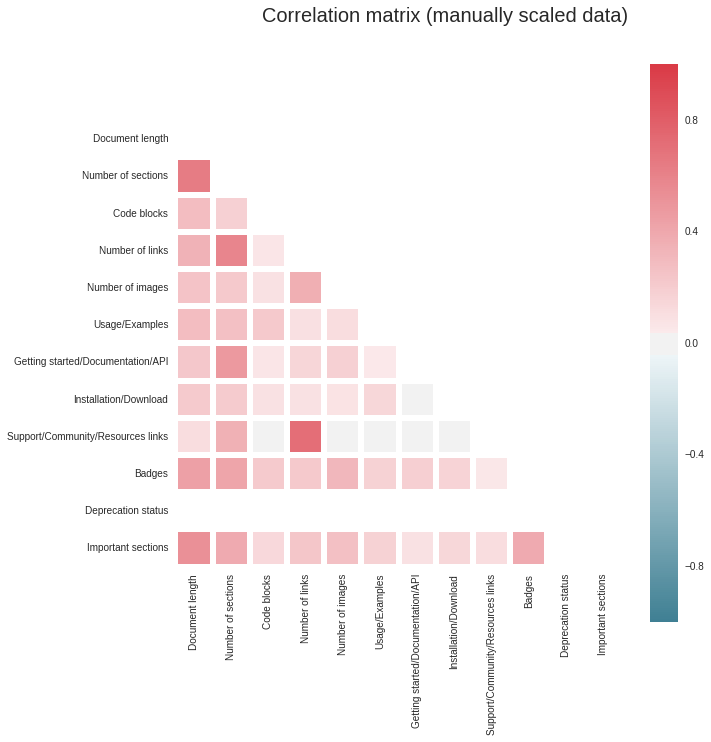

In [7]:
# visualisation of data after manual scaling -- correlation matrix

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/manually-scaled.csv', usecols=list(range(1, 13)))

# compute the correlation matrix
corr = data.corr()

# set background color
sns.set(style="white")

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# add visualisation name
f.suptitle('Correlation matrix (manually scaled data)', size=20)

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, linewidths=5, ax=ax, square=True)

plt.show()

/home/nevyk/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


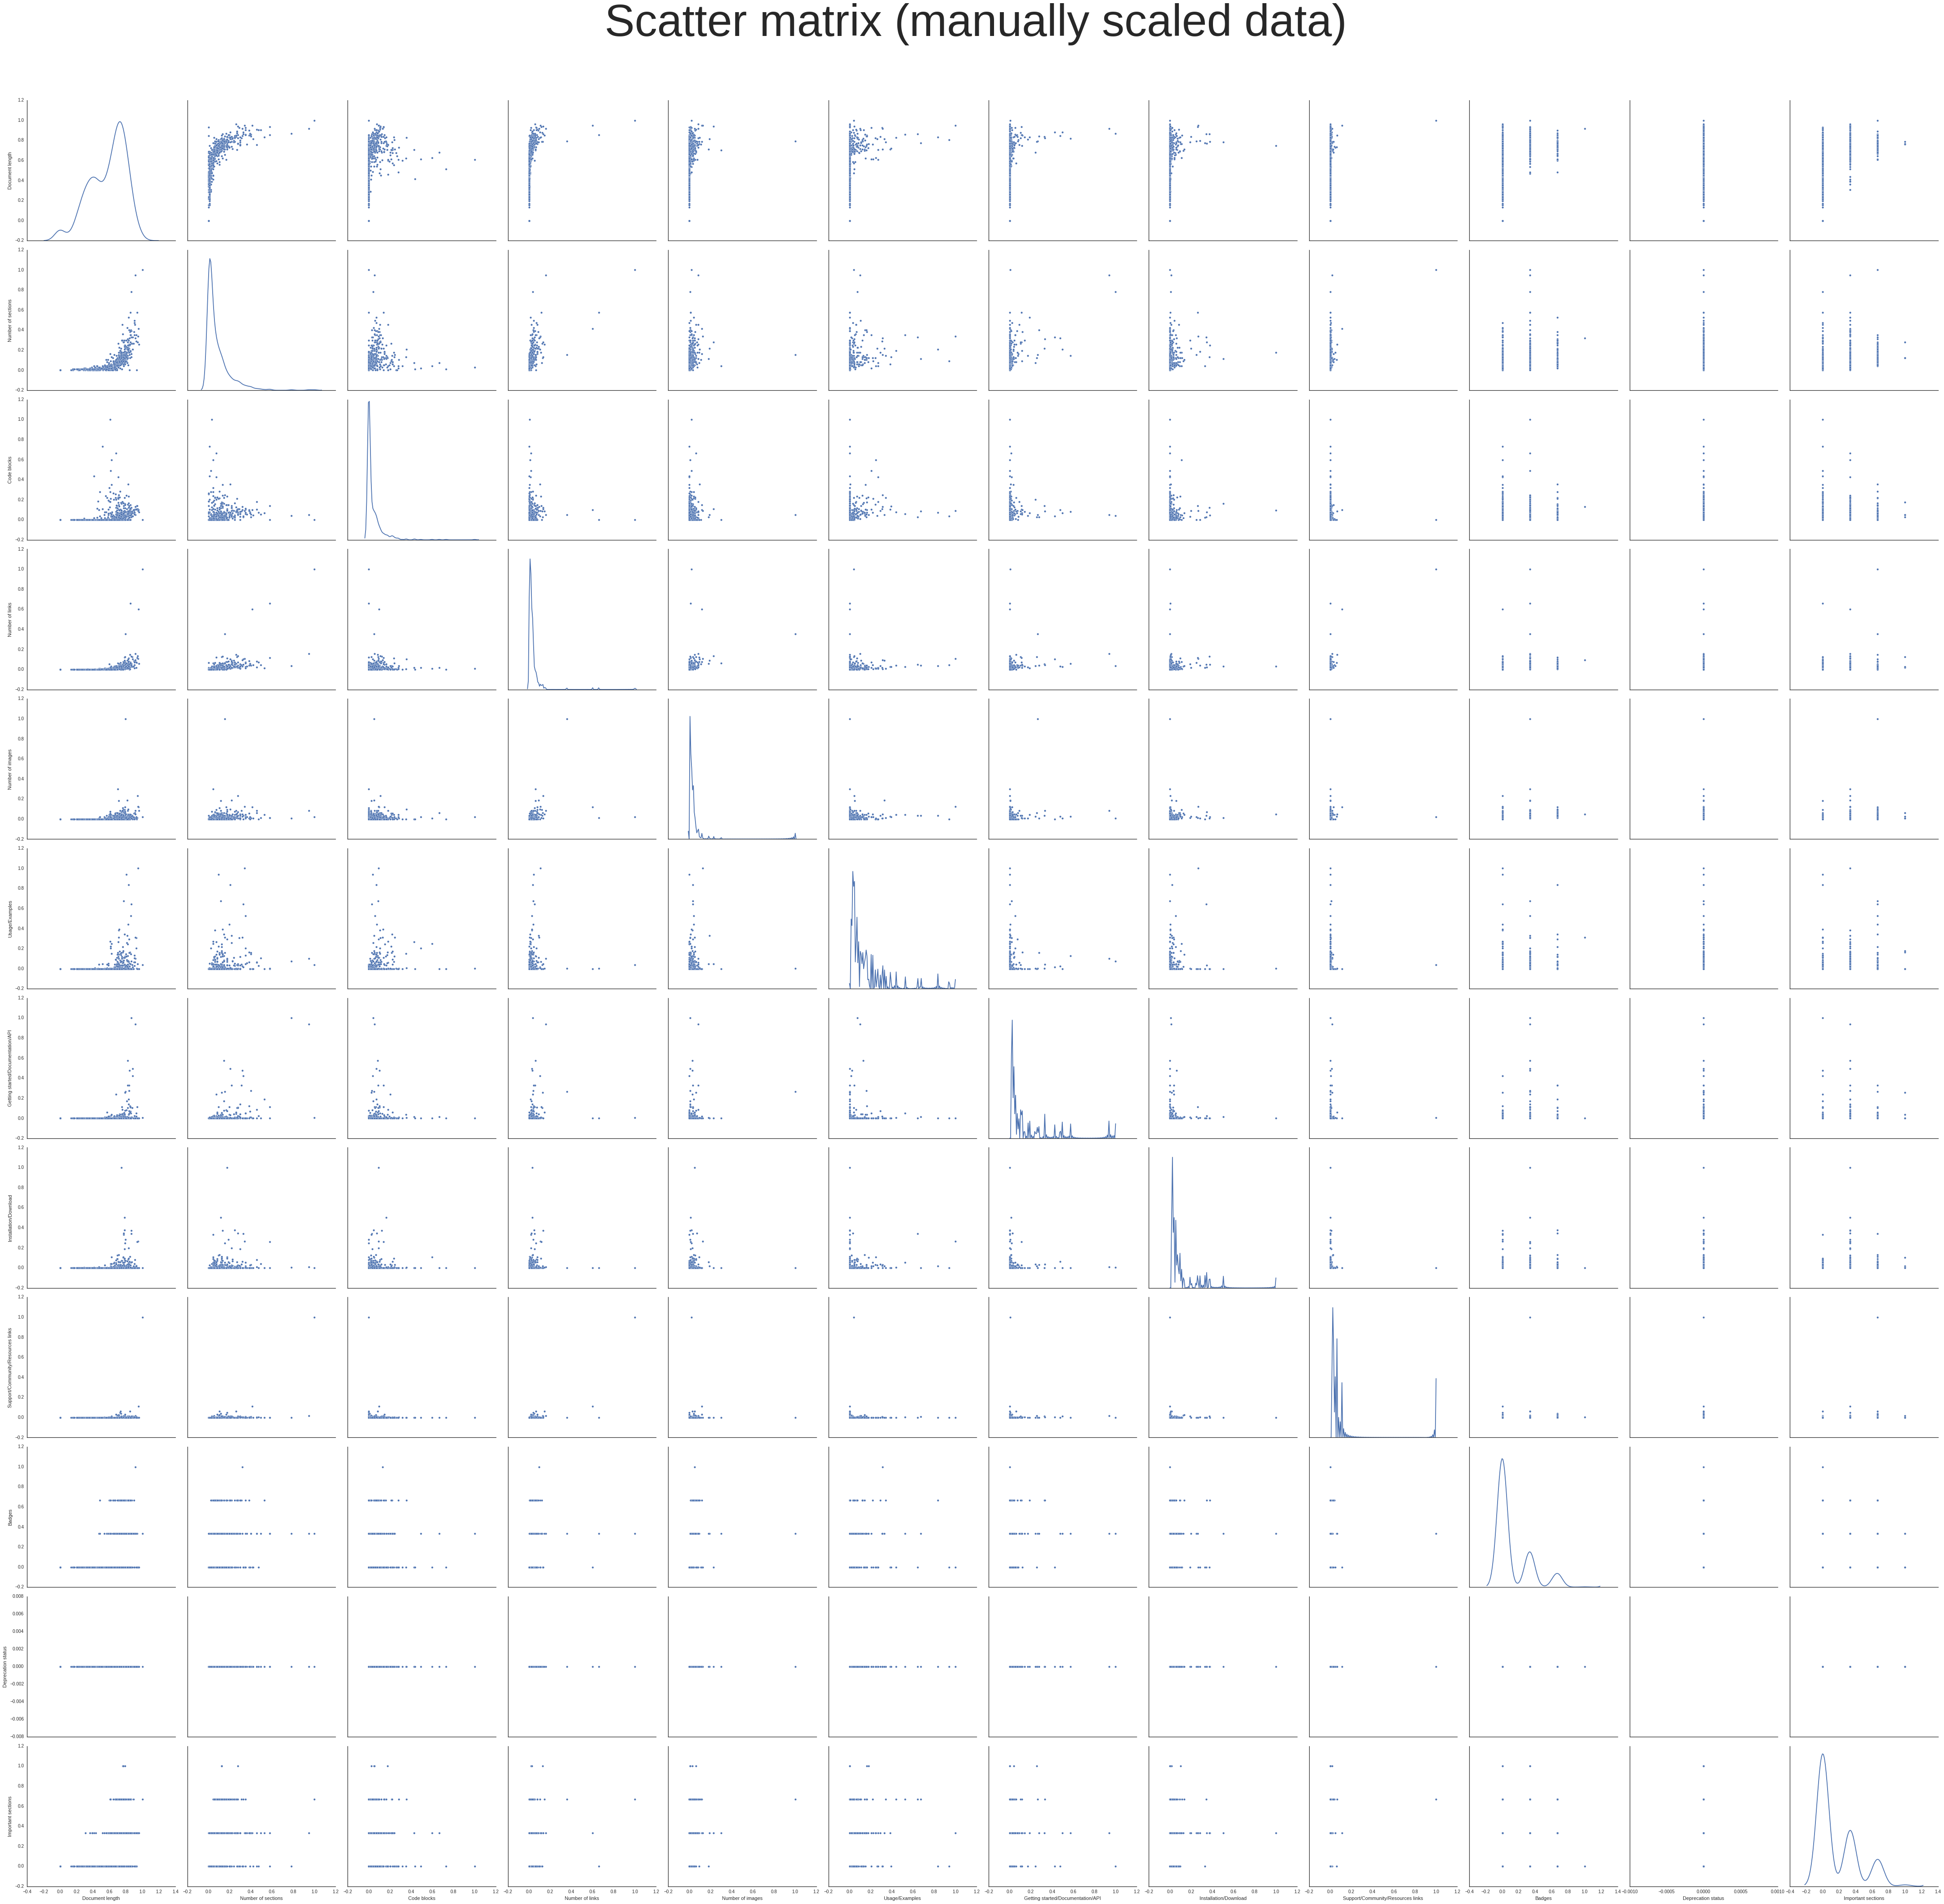

In [8]:
# visualisation of data after manual scaling -- scatter matrix

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/manually-scaled.csv', usecols=list(range(1, 13)))

# set background color
sns.set(style="white")

# draw the scatter matrix
grid = sns.pairplot(data, size=5, diag_kind='kde')
grid.fig.subplots_adjust(top=0.93)
grid.fig.suptitle('Scatter matrix (manually scaled data)', size=100)

plt.show()

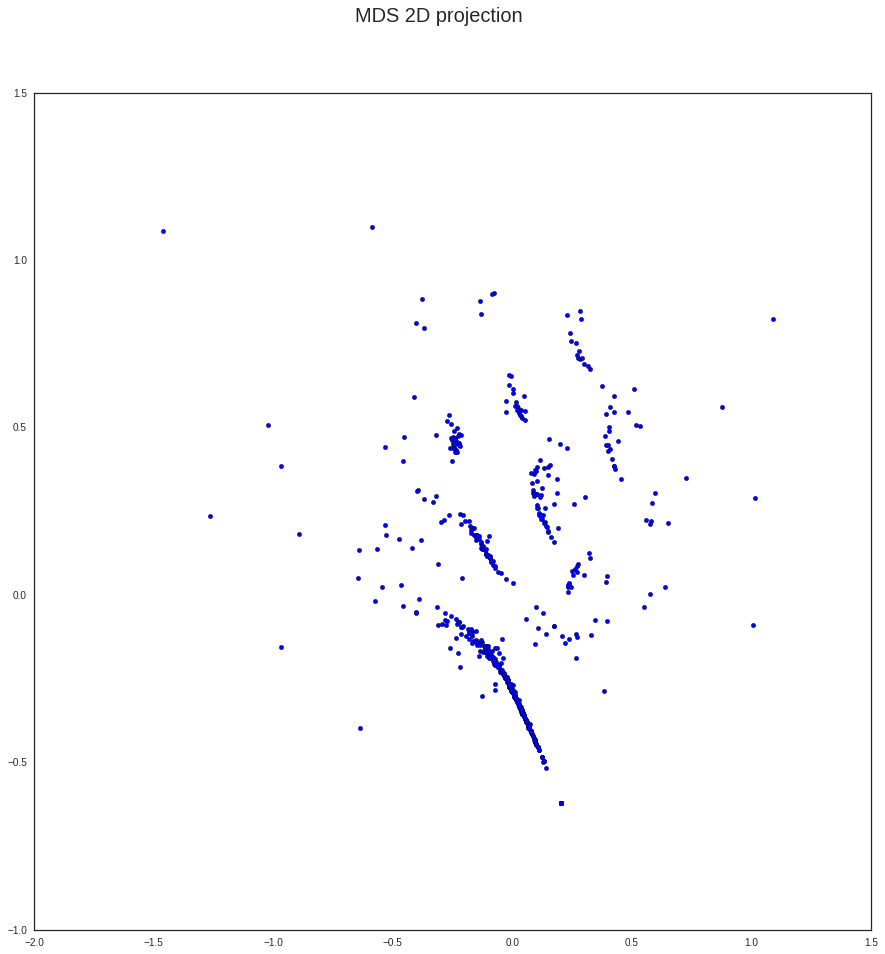

In [9]:
# visualisation of data after manual scaling -- 2D projection using MDS manifold learning dimensionality reduction

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

data = pd.read_csv('../data/manually-scaled.csv', usecols=list(range(1, 13)))
X = data.values

mds = MDS(n_components=2, metric=True, dissimilarity='euclidean', random_state=3)
X_mds = mds.fit_transform(X)

plt.figure(figsize=(15, 15)).suptitle('MDS 2D projection', size=20)
plt.subplot(111)
plt.scatter(X_mds[0:,0], X_mds[0:,1])

plt.show()

## Statistical scaling with visualisations

Then we can try to use some `scikit-learn` methods to scale our dataset in statistical meaning. We examine four methods (`standard`, `minmax`, `maxabs` and `robust`), then project scaled dataset into 2D using MDS manifold learning and try to observe how (if at all) they change our data. As the result of these experiments we can attempt to suggest the best scaling method for our dataset.

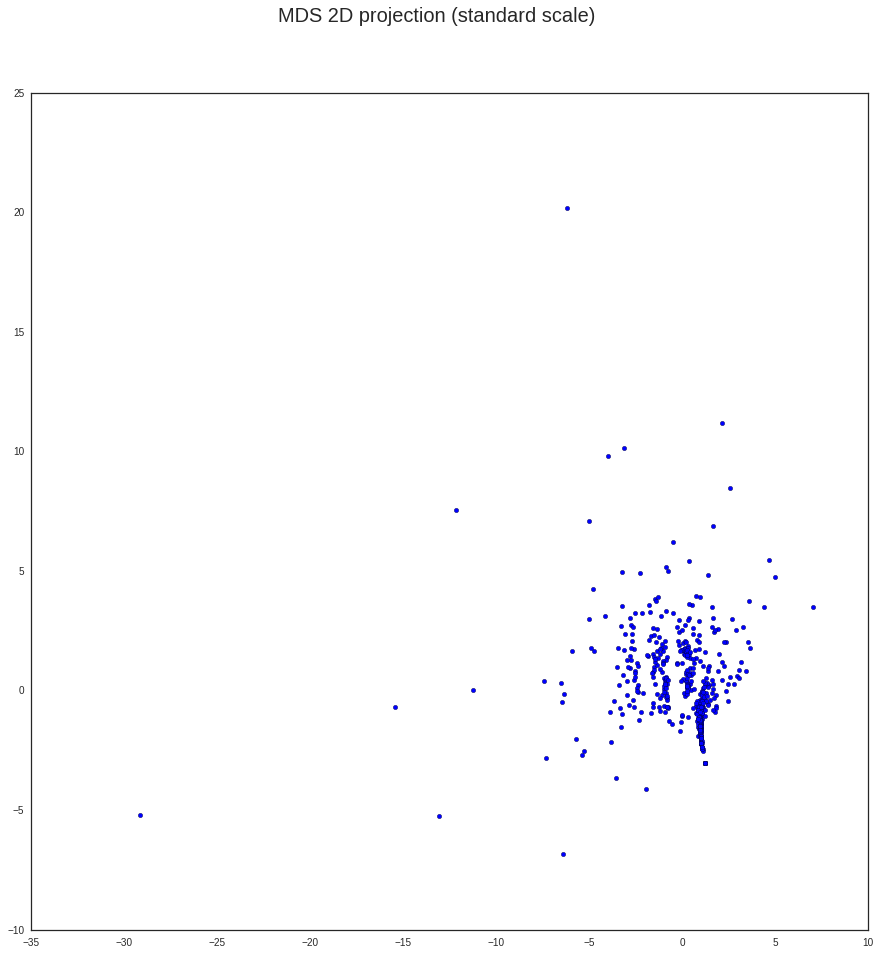

In [10]:
# statistical features scaling and visualisation -- standard scaling

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.manifold import MDS

data = pd.read_csv('../data/manually-scaled.csv', usecols=list(range(1, 13)))

# use standard scaling
X = data.values
X_scaled = scale(X)

mds = MDS(n_components=2, metric=True, dissimilarity='euclidean', random_state=3)
X_mds = mds.fit_transform(X_scaled)

plt.figure(figsize=(15, 15)).suptitle('MDS 2D projection (standard scale)', size=20)
plt.subplot(111)
plt.scatter(X_mds[0:,0], X_mds[0:,1])

plt.show()

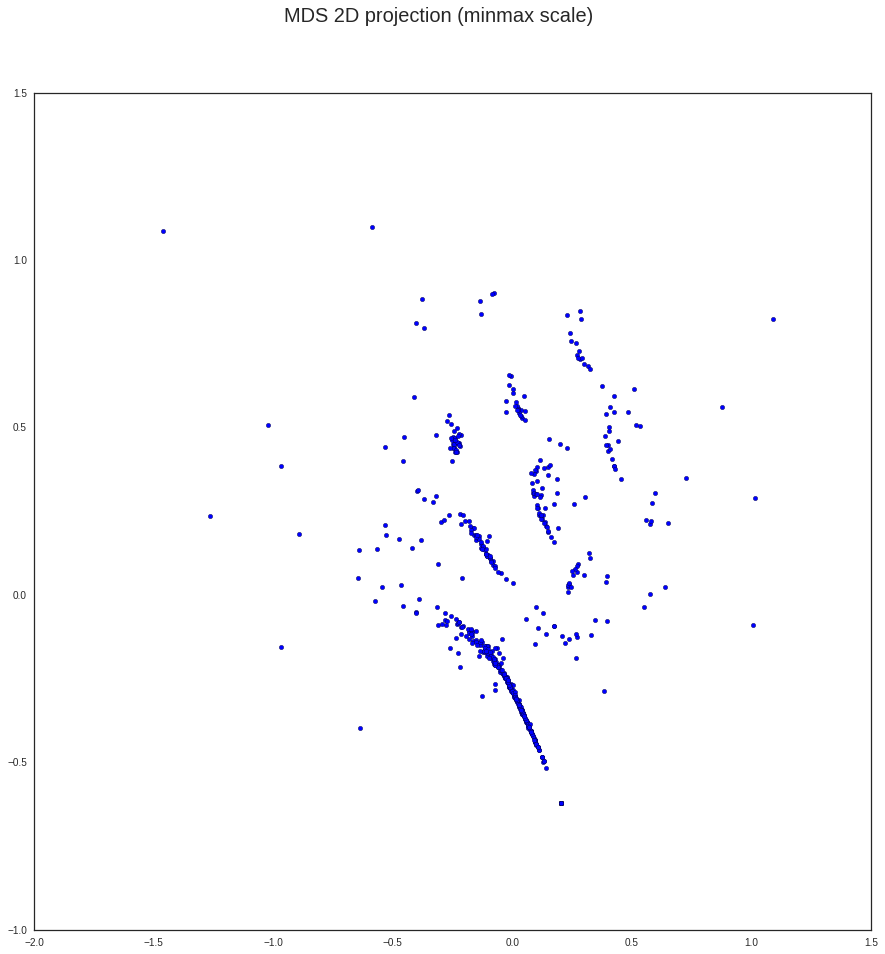

In [11]:
# statistical features scaling and visualisation -- minmax scaling

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import MDS

data = pd.read_csv('../data/manually-scaled.csv', usecols=list(range(1, 13)))

# use standard scaling
X = data.values
X_scaled = minmax_scale(X)

mds = MDS(n_components=2, metric=True, dissimilarity='euclidean', random_state=3)
X_mds = mds.fit_transform(X_scaled)

plt.figure(figsize=(15, 15)).suptitle('MDS 2D projection (minmax scale)', size=20)
plt.subplot(111)
plt.scatter(X_mds[0:,0], X_mds[0:,1])

plt.show()

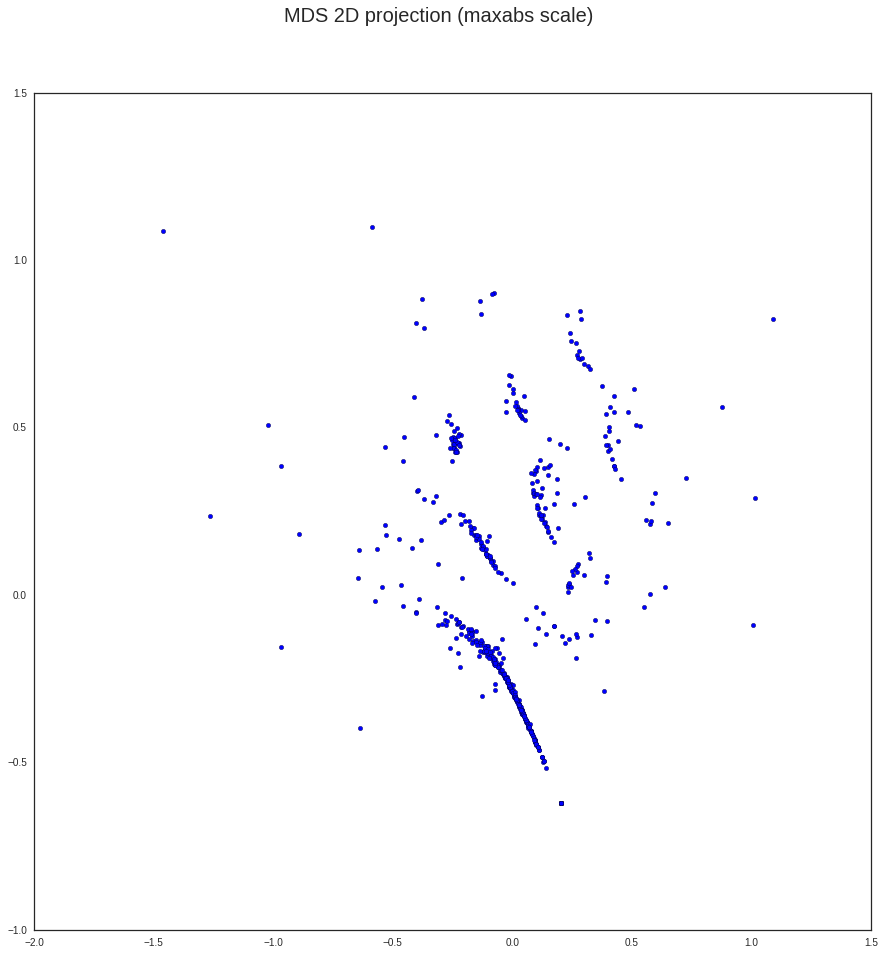

In [12]:
# statistical features scaling and visualisation -- maxabs scaling

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import maxabs_scale
from sklearn.manifold import MDS

data = pd.read_csv('../data/manually-scaled.csv', usecols=list(range(1, 13)))

# use standard scaling
X = data.values
X_scaled = maxabs_scale(X)

mds = MDS(n_components=2, metric=True, dissimilarity='euclidean', random_state=3)
X_mds = mds.fit_transform(X_scaled)

plt.figure(figsize=(15, 15)).suptitle('MDS 2D projection (maxabs scale)', size=20)
plt.subplot(111)
plt.scatter(X_mds[0:,0], X_mds[0:,1])

plt.show()

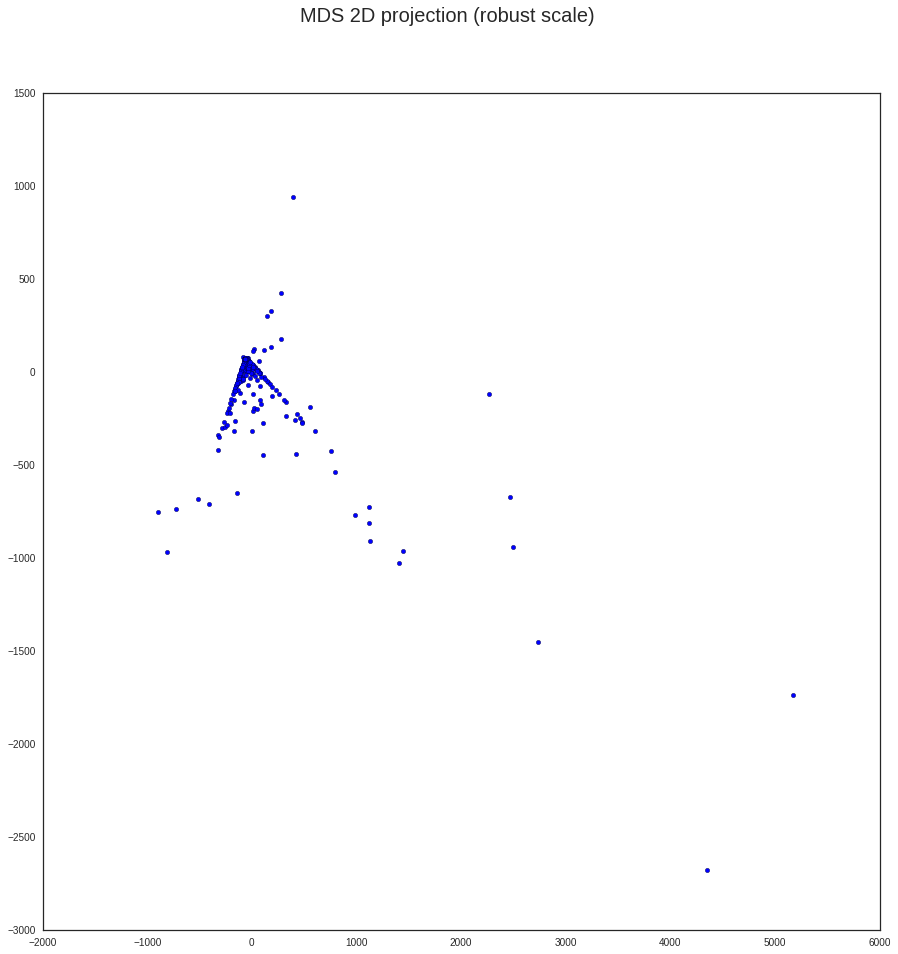

In [13]:
# statistical features scaling and visualisation -- robust scaling

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import robust_scale
from sklearn.manifold import MDS

data = pd.read_csv('../data/manually-scaled.csv', usecols=list(range(1, 13)))

# use standard scaling
X = data.values
X_scaled = robust_scale(X)

mds = MDS(n_components=2, metric=True, dissimilarity='euclidean', random_state=3)
X_mds = mds.fit_transform(X_scaled)

plt.figure(figsize=(15, 15)).suptitle('MDS 2D projection (robust scale)', size=20)
plt.subplot(111)
plt.scatter(X_mds[0:,0], X_mds[0:,1])

plt.show()

## Conclusion

At first, we scaled the features manually using our knowledge about their meaning. Then we tried four methods of statistical scaling. The best results came perhaps from standard scaling. Obviously there are some outliers which may cause problems but that should be solved at the appropriate project stage. It seems that minmax and maxabs scaling don't change data at all but that's not surprising since our data have been already in [0, 1] range. However, they should be tried in the future because it seems that there are already some clusters but it can be just coincidence caused by 2D projection. Robust scaling produced strange triangular shape so this method won't be probably useful.